In [1]:
!pip install transformers -q
# !pip install tensorflow==2.15.1 -q
# !pip install tensorflow-hub==0.14.0 -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

import os
import json
import random
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

2025-05-02 11:49:40.073025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746186580.262817      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746186580.318956      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!nvcc --version
!cat /usr/include/cudnn_version.h | grep CUDNN_MAJOR -A 2

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
#define CUDNN_MAJOR 9
#define CUDNN_MINOR 2
#define CUDNN_PATCHLEVEL 1
--
#define CUDNN_VERSION (CUDNN_MAJOR * 10000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

/* cannot use constexpr here since this is a C-only file */


In [4]:
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available: 1


In [5]:
BASE_DIR = "/kaggle/input/flickr-image-dataset/flickr30k_images"
WORK_DIR = "/kaggle/working"

os.listdir(BASE_DIR)

['flickr30k_images', 'results.csv']

In [6]:
# Reading the results file.
df = pd.read_csv(f"{BASE_DIR}/results.csv", sep='|', names=['image_name', 'comment_number', 'comment'])

In [7]:
df.head()

,image_name,comment_number,comment
0,image_name,comment_number,comment
1,1000092795.jpg,0,Two young guys with shaggy hair look at their...
2,1000092795.jpg,1,"Two young , White males are outside near many..."
3,1000092795.jpg,2,Two men in green shirts are standing in a yard .
4,1000092795.jpg,3,A man in a blue shirt standing in a garden .


In [8]:
df = df.drop(columns=['comment_number'])
df = df.drop(index=0).reset_index(drop=True)
df = df.rename(columns={'comment' : 'caption'})

In [9]:
df.head()

,image_name,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  158915 non-null  object
 1   caption     158914 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [11]:
df.describe()

,image_name,caption
count,158915,158914
unique,31783,158438
top,998845445.jpg,Two dogs playing in the snow .
freq,5,7


In [12]:
df.isnull().sum()

image_name    0
caption       1
dtype: int64

In [13]:
# Deleting null values
df.dropna(inplace=True)

In [14]:
df.isnull().sum()

image_name    0
caption       0
dtype: int64

In [15]:
df['processed_caption'] = "[START] " + df['caption'].str.lower().str.replace('[^\w\s]', '') + " [END]"
df['image_filepath'] = df['image_name'].apply(
    lambda x: os.path.join(BASE_DIR, "flickr30k_images", x)
)

In [16]:
df.head()

,image_name,caption,processed_caption,image_filepath
0,1000092795.jpg,Two young guys with shaggy hair look at their...,[START] two young guys with shaggy hair look ...,/kaggle/input/flickr-image-dataset/flickr30k_i...
1,1000092795.jpg,"Two young , White males are outside near many...","[START] two young , white males are outside n...",/kaggle/input/flickr-image-dataset/flickr30k_i...
2,1000092795.jpg,Two men in green shirts are standing in a yard .,[START] two men in green shirts are standing ...,/kaggle/input/flickr-image-dataset/flickr30k_i...
3,1000092795.jpg,A man in a blue shirt standing in a garden .,[START] a man in a blue shirt standing in a g...,/kaggle/input/flickr-image-dataset/flickr30k_i...
4,1000092795.jpg,Two friends enjoy time spent together .,[START] two friends enjoy time spent together...,/kaggle/input/flickr-image-dataset/flickr30k_i...


In [17]:
# Step 1: Get unique image names
unique_images = df['image_name'].unique()

# Step 2: Split into train (80%) and temp (20%)
train_images, temp_images = train_test_split(unique_images, test_size=0.2, random_state=42)

# Step 3: Split temp into validation (10%) and test (10%)
valid_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

# Step 4: Filter the DataFrame
train_df = df[df['image_name'].isin(train_images)]
valid_df = df[df['image_name'].isin(valid_images)]
test_df = df[df['image_name'].isin(test_images)]

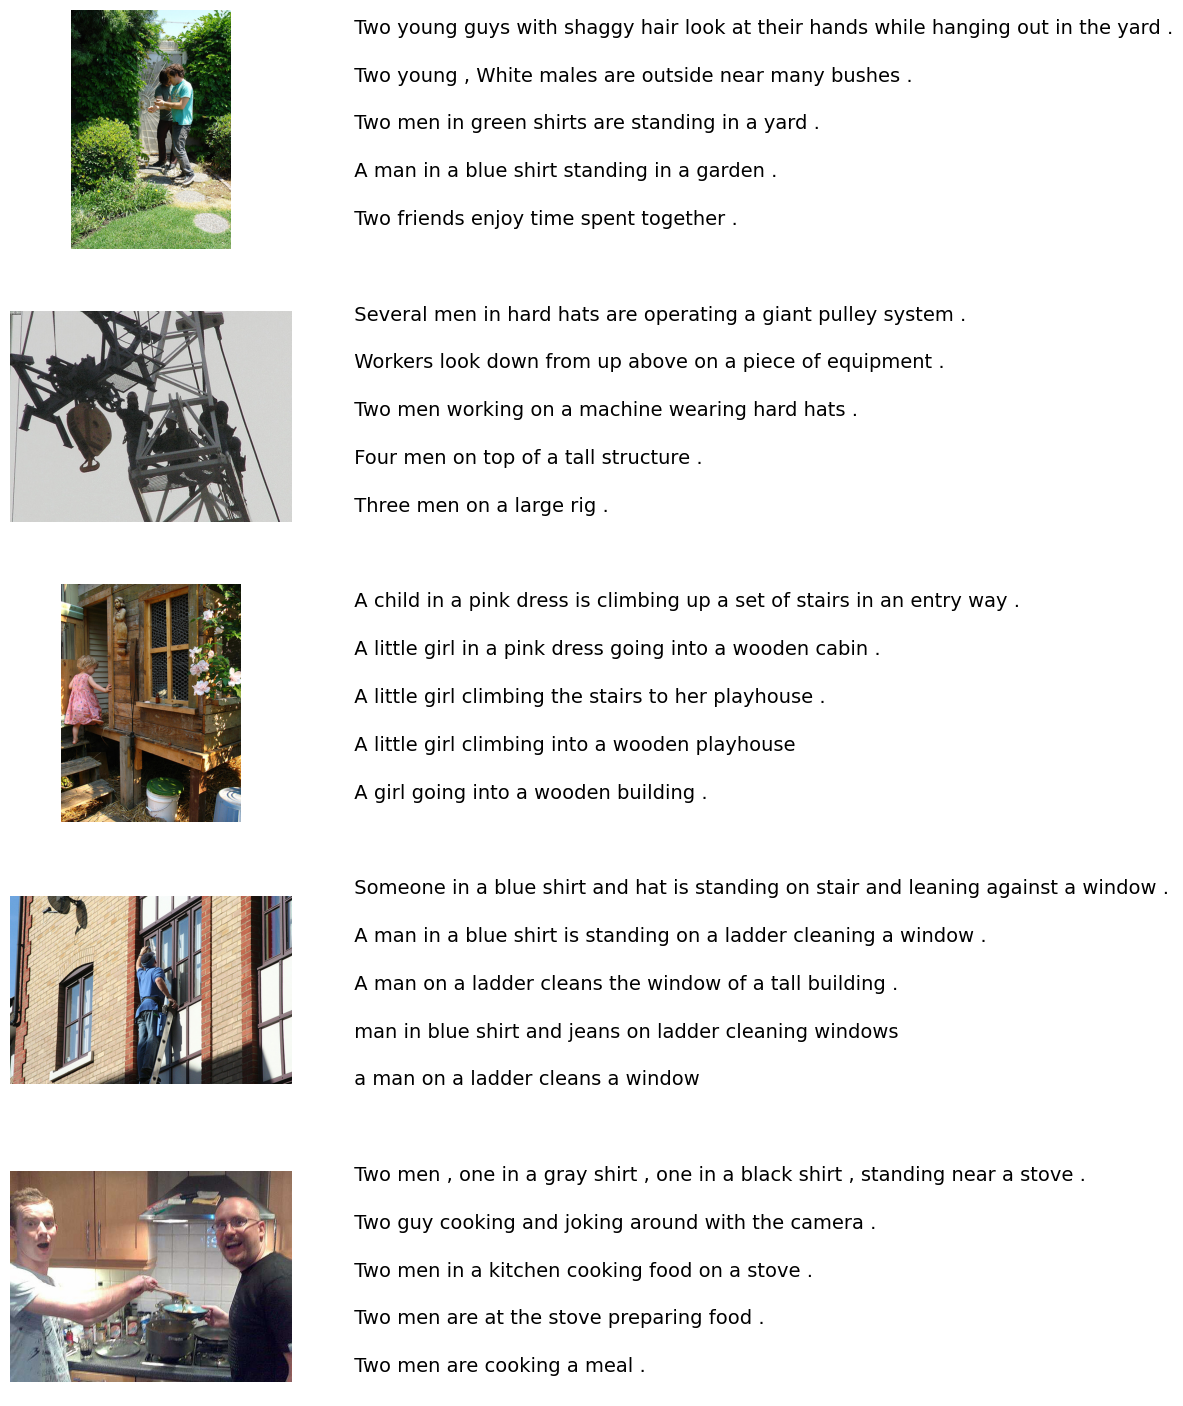

In [18]:
sample_data = train_df.groupby('image_name')['caption'].agg(list).iloc[:5]

fig, axes = plt.subplots(5, 2, figsize=(8, 18))

for ax_row, index, sample in zip(axes, sample_data.index, sample_data):
    
    ax_row[0].imshow(Image.open(os.path.join(BASE_DIR, "flickr30k_images", index)))
    ax_row[0].axis("off")
    text_y = 0.9
    for cap in sample:
        ax_row[1].text(0, text_y, cap, fontsize=14)
        text_y -= 0.2
    ax_row[1].axis("off")

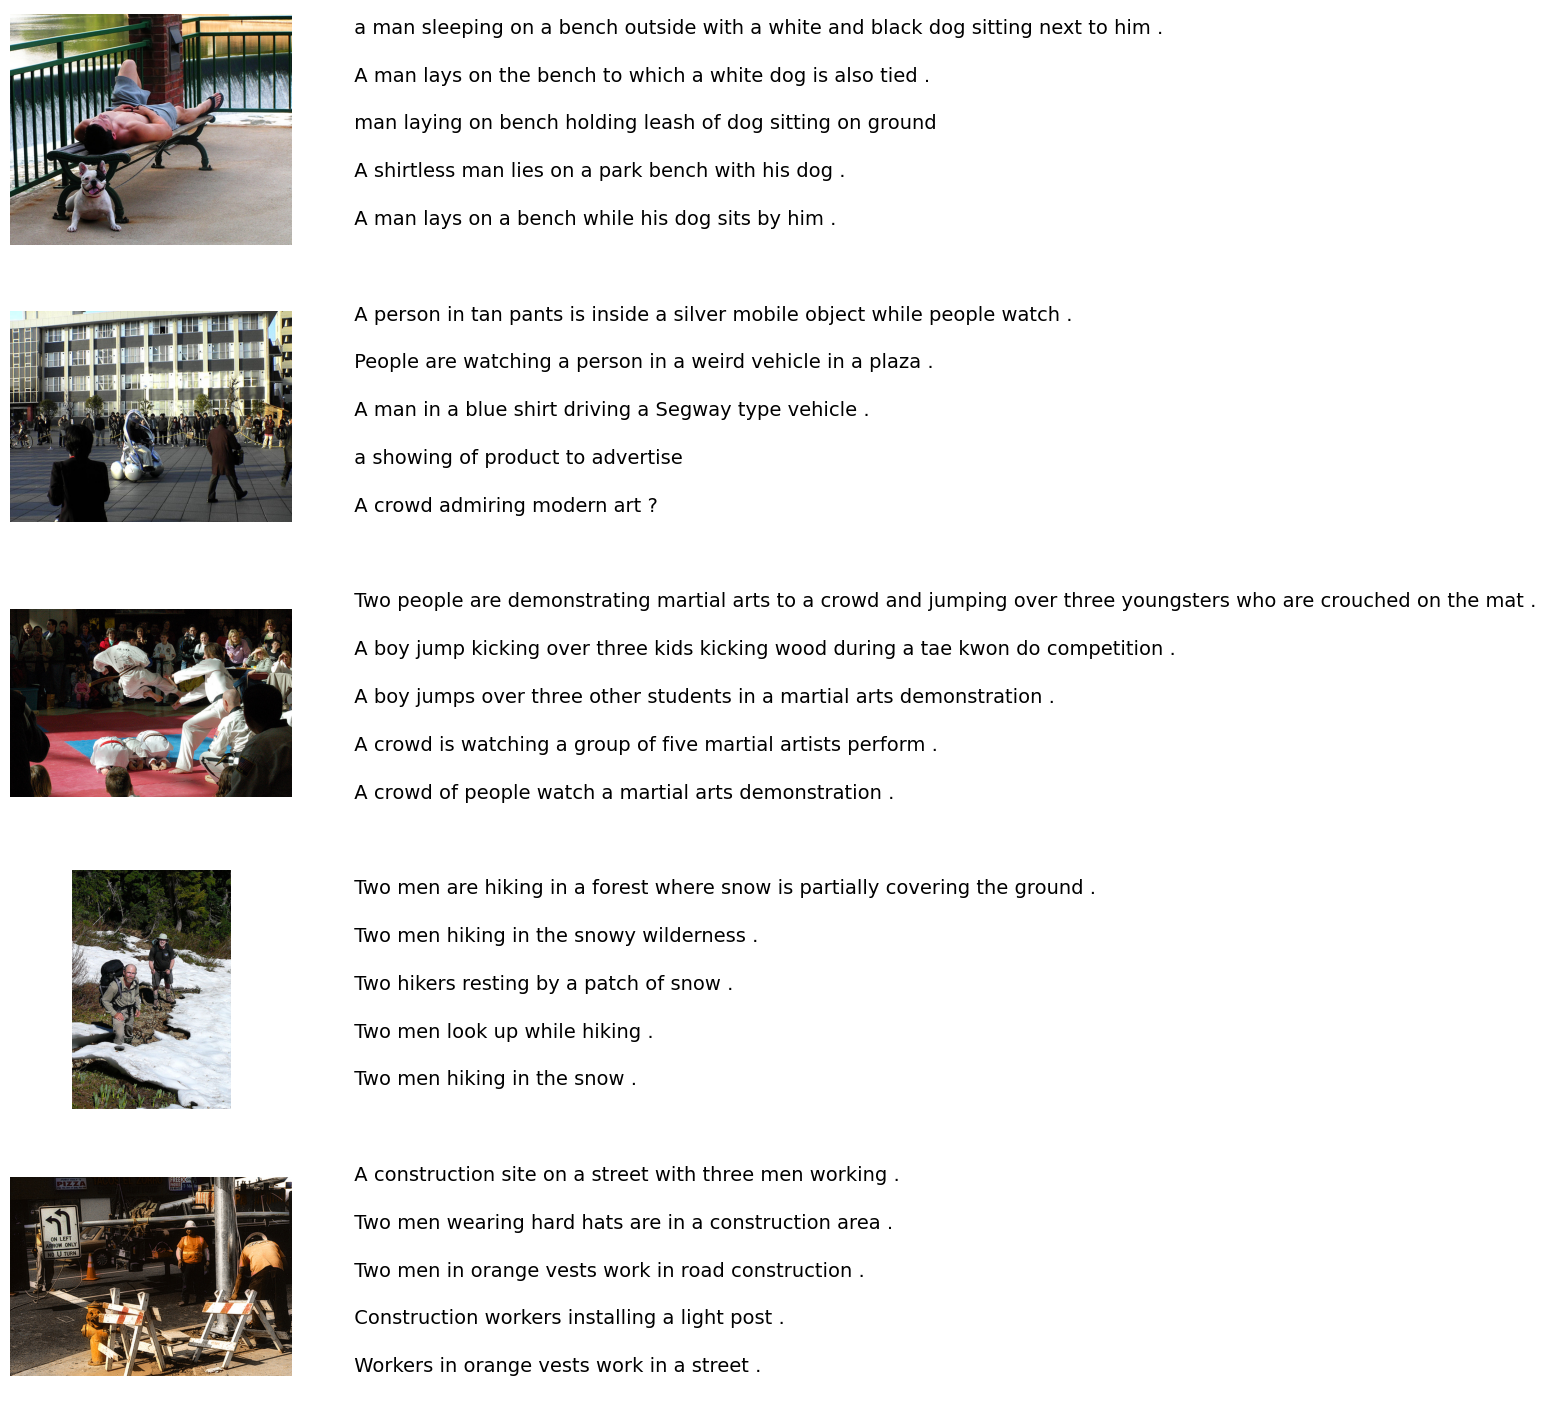

In [19]:
sample_data = test_df.groupby('image_name')['caption'].agg(list).iloc[:5]

fig, axes = plt.subplots(5, 2, figsize=(8, 18))

for ax_row, index, sample in zip(axes, sample_data.index, sample_data):
    
    ax_row[0].imshow(Image.open(os.path.join(BASE_DIR, "flickr30k_images", index)))
    ax_row[0].axis("off")
    text_y = 0.9
    for cap in sample:
        ax_row[1].text(0, text_y, cap, fontsize=14)
        text_y -= 0.2
    ax_row[1].axis("off")

In [20]:
train_vocabulary = train_df["processed_caption"].str.split(" ").explode().value_counts()
print(len(train_vocabulary[train_vocabulary>=25]))

2878


In [21]:
from tokenizers import BertWordPieceTokenizer

# Initialize an empty BERT tokenizer
tokenizer = BertWordPieceTokenizer(
    #reserved_tokens=["[UNK]", "[START]", "[END]", "[PAD]"],
    unk_token="[UNK]",
    #trainer_params=None,
    #vocab_size=8000,
    clean_text=False,
    lowercase=False,
)

tokenizer.train_from_iterator(
    train_df["processed_caption"].tolist(),
    vocab_size=3000,
    special_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
)

In [22]:
# Encoding a sentence
example_captions = valid_df["processed_caption"].iloc[:10].tolist()
example_tokenized_captions = tokenizer.encode_batch(example_captions)

for caption, tokenized_cap in zip(example_captions, example_tokenized_captions):
    print(f"{caption} -> {tokenized_cap.tokens}")

[START]  a man sits in a chair while holding a large stuffed animal of a lion . [END] -> ['[START]', 'a', 'man', 'sits', 'in', 'a', 'chair', 'while', 'holding', 'a', 'large', 'stuffed', 'animal', 'of', 'a', 'li', '##on', '.', '[END]']
[START]  a man is sitting on a chair holding a large stuffed animal . [END] -> ['[START]', 'a', 'man', 'is', 'sitting', 'on', 'a', 'chair', 'holding', 'a', 'large', 'stuffed', 'animal', '.', '[END]']
[START]  a man completes the finishing touches on a stuffed lion . [END] -> ['[START]', 'a', 'man', 'comple', '##te', '##s', 'the', 'finish', '##ing', 'tou', '##ches', 'on', 'a', 'stuffed', 'li', '##on', '.', '[END]']
[START]  a man holds a large stuffed lion toy . [END] -> ['[START]', 'a', 'man', 'holds', 'a', 'large', 'stuffed', 'li', '##on', 'toy', '.', '[END]']
[START]  a man is smiling at a stuffed lion [END] -> ['[START]', 'a', 'man', 'is', 'smiling', 'at', 'a', 'stuffed', 'li', '##on', '[END]']
[START]  an asian man wearing a black suit stands near a d

In [23]:
vocab = tokenizer.get_vocab()

for token in ["[UNK]", "[PAD]", "[START]", "[END]"]:
    print(f"{token} -> {vocab[token]}")

[UNK] -> 1
[PAD] -> 0
[START] -> 2
[END] -> 3


In [24]:
def parse_image(filepath, resize_height, resize_width):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [resize_height, resize_width])
    image = image*2.0 - 1.0
    return image

In [25]:
def generate_tokenizer(captions_df, n_vocab):
    """ Generate the tokenizer with given captions """
    
    # Define the tokenizer
    tokenizer = BertWordPieceTokenizer(
        unk_token="[UNK]",
        clean_text=False,
        lowercase=False,
    )
    
    # Train the tokenizer
    tokenizer.train_from_iterator(
        captions_df["processed_caption"].tolist(),
        vocab_size=n_vocab,
        special_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
    )
    
    return tokenizer

In [26]:
def generate_tf_dataset(image_captions_df, tokenizer=None, n_vocab=5000, pad_length=33, batch_size=32, training=False):
    """ Generate the tf.data.Dataset"""
    
    # If the tokenizer is not available, create one
    if not tokenizer:
        tokenizer = generate_tokenizer(image_captions_df, n_vocab)
        
    # Get the caption IDs using the tokenizer
    image_captions_df["caption_token_ids"] = [enc.ids for enc in tokenizer.encode_batch(image_captions_df["processed_caption"])]
    
    vocab = tokenizer.get_vocab()
    
    # Add the padding to short sentences and truncate long ones
    image_captions_df["caption_token_ids"] = image_captions_df["caption_token_ids"].apply(
        lambda x: x+[vocab["[PAD]"]]*(pad_length - len(x) + 2) if pad_length + 2 >= len(x) else x[:pad_length + 1] + [x[-1]]
    ) 
    
    # Create a dataset with images and captions
    dataset = tf.data.Dataset.from_tensor_slices({
        "image_filepath": image_captions_df["image_filepath"],
        "caption_token_ids": np.array(image_captions_df["caption_token_ids"].tolist())
    })
    
    # Each sample in our dataset consists of
    # (image, caption token IDs, position IDs), (caption token IDs offset by 1)
    dataset = dataset.map(
        lambda x: (
            (parse_image(x["image_filepath"], 224, 224), x["caption_token_ids"][:-1], tf.range(pad_length+1, dtype='float32')), x["caption_token_ids"]
        )
    )
    
    # Shuffle and batch data in the training mode
    if training:
        dataset = dataset.shuffle(buffer_size=batch_size*10)
    
    dataset = dataset.batch(batch_size)
    
    return dataset, tokenizer

In [27]:
n_vocab=3000
batch_size=2
sample_dataset, sample_tokenizer = generate_tf_dataset(train_df, n_vocab=n_vocab, pad_length=10, batch_size=batch_size, training=True)
for i in sample_dataset.take(1):
    print(i)

I0000 00:00:1746186619.120680      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


((<tf.Tensor: shape=(2, 224, 224, 3), dtype=float32, numpy=
array([[[[ 0.20156944,  0.29043496,  0.21462965],
         [ 0.23782337,  0.331941  ,  0.25350964],
         [ 0.32136798,  0.36828864,  0.31832278],
         ...,
         [ 0.64688015,  0.64688015,  0.6311939 ],
         [ 0.64778924,  0.64778924,  0.63210297],
         [ 0.6519244 ,  0.6519244 ,  0.6362381 ]],

        [[ 0.24481547,  0.29964733,  0.23695076],
         [ 0.3133372 ,  0.39166355,  0.32111037],
         [ 0.41918337,  0.45641172,  0.41127586],
         ...,
         [ 0.66079295,  0.66079295,  0.6451067 ],
         [ 0.63806033,  0.6381303 ,  0.622409  ],
         [ 0.645295  ,  0.645295  ,  0.62960875]],

        [[ 0.14320171,  0.16655612,  0.12320971],
         [ 0.17348766,  0.2178154 ,  0.16035736],
         [ 0.2511859 ,  0.26687217,  0.22891712],
         ...,
         [ 0.6474838 ,  0.652771  ,  0.62122333],
         [ 0.6360967 ,  0.651783  ,  0.6282536 ],
         [ 0.64856637,  0.64856637,  0.63288

In [28]:
# !pip install tensorflow-hub==0.14.0 -q

In [29]:
print(tf.__version__)

2.18.0


In [39]:
import tensorflow_hub as hub
import tensorflow.keras.backend as K
import tf_keras
# Problem with tf.keras requires tf version 2.15.1

K.clear_session()

image_input = tf_keras.layers.Input(shape=(224, 224, 3))
model = tf_keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-s16-fe/1", trainable=False)
])
image_features = model(image_input)



In [40]:
print(f"Final representation shape: {image_features.shape}")

Final representation shape: (None, 384)


In [41]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available: 1


In [44]:
class SelfAttentionLayer(tf_keras.layers.Layer):
    """ Defines the computations in the self attention layer """
    
    def __init__(self, d):        
        super(SelfAttentionLayer, self).__init__()
        # Feature dimensionality of the output
        self.d = d
    
    def build(self, input_shape):
        # Query weight matrix
        self.Wq = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )        
        # Key weight matrix
        self.Wk = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Value weight matrix
        self.Wv = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
    
    def call(self, q_x, k_x, v_x, mask=None):
        
        q = tf.matmul(q_x,self.Wq) #[None, t, d]
        k = tf.matmul(k_x,self.Wk) #[None, t, d]
        v = tf.matmul(v_x,self.Wv) #[None, t, d]
        
        # Computing the final output
        h = tf_keras.layers.Attention(causal=True)([
            q, #q
            v, #v
            k, #k
        ], mask=[None, mask]) # [None, t, t] . [None, t, d] => [None, t, d]
        
        return h
    
    
class TransformerDecoderLayer(tf_keras.layers.Layer):
    """ The Decoder layer """
    
    def __init__(self, d, n_heads):
        super(TransformerDecoderLayer, self).__init__()
        # Feature dimensionality
        self.d = d
        
        # Dimensionality of a head
        self.d_head = int(d/n_heads) 
        
        # Number of heads
        self.n_heads = n_heads
        
        # Actual attention heads
        self.attn_heads = [SelfAttentionLayer(self.d_head) for i in range(self.n_heads)]
        
        # Fully connected layers
        self.fc1_layer = tf_keras.layers.Dense(512, activation='relu')
        self.fc2_layer = tf_keras.layers.Dense(d)
        
        self.add_layer = tf_keras.layers.Add()
        self.norm1_layer = tf_keras.layers.LayerNormalization()
        self.norm2_layer = tf_keras.layers.LayerNormalization()
        
    
    def _compute_multihead_output(self, x):
        """ Computing the multi head attention output"""
        outputs = [head(x, x, x) for head in self.attn_heads]            
        outputs = tf.concat(outputs, axis=-1)
        return outputs
        
    def call(self, x):
        
        
        # Multi head attention layer output
        h1 = self._compute_multihead_output(x)
        
        h1_add = self.add_layer([x, h1])
        h1_norm = self.norm1_layer(h1_add)
        
        # Fully connected outputs
        h2_1 = self.fc1_layer(h1_norm)
        h2_2 = self.fc2_layer(h2_1)
        
        h2_add = self.add_layer([h1, h2_2])
        h2_norm = self.norm2_layer(h2_add)
        
        
        return h2_norm
    

# Input layer
caption_input = tf_keras.layers.Input(shape=(None,))
position_input = tf_keras.layers.Input(shape=(None,))
d_model = 384

# Token embeddings
input_embedding = tf_keras.layers.Embedding(len(tokenizer.get_vocab()), d_model, mask_zero=True)

# Position embeddings
position_embedding = tf_keras.layers.Lambda(
    lambda x: tf.where(
        tf.math.mod(tf.repeat(tf.expand_dims(x, axis=-1), d_model, axis=-1), 2)==0,
        tf.math.sin(
            #tf.repeat(tf.expand_dims(x, axis=-1), d_model, axis=-1) /
            tf.expand_dims(x, axis=-1) /
            10000**(2*tf.reshape(tf.range(d_model, dtype='float32'),[1,1, -1])/d_model)
        ),
        tf.math.cos(
            tf.expand_dims(x, axis=-1) /
            10000**(2*tf.reshape(tf.range(d_model, dtype='float32'),[1,1, -1])/d_model)
        )
    )
)

# Combined token position embeddings
embed_out = input_embedding(caption_input) + position_embedding(position_input)
# Concatenate image caption and token embeddings
image_caption_embed_out = tf_keras.layers.Concatenate(axis=1)([tf.expand_dims(image_features,axis=1), embed_out])

# Generate hidden representation with Transformer decoder layer
out = image_caption_embed_out
for l in range(4):
    out  = TransformerDecoderLayer(d_model, 64)(out)

# Final prediction layer
final_out = tf_keras.layers.Dense(n_vocab, activation='softmax')(out)

# Define the final model and compile
full_model = tf_keras.models.Model(inputs=[image_input, caption_input, position_input], outputs=final_out)
full_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 sequential (Sequential)     (None, 384)                  2166566   ['input_1[0][0]']             
                                                          4                                   

In [45]:
import collections
import math


def _get_ngrams(segment, max_order):
    """Extracts all n-grams upto a given maximum order from an input segment.

      Args:
        segment: text segment from which n-grams will be extracted.
        max_order: maximum length in tokens of the n-grams returned by this
            methods.

      Returns:
        The Counter containing all n-grams upto max_order in segment
        with a count of how many times each n-gram occurred.
    """
    ngram_counts = collections.Counter()
    for order in range(1, max_order + 1):
        for i in range(0, len(segment) - order + 1):
            ngram = tuple(segment[i:i+order])
            ngram_counts[ngram] += 1
    return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
    """Computes BLEU score of translated segments against one or more references.

      Args:
        reference_corpus: list of lists of references for each translation. Each
            reference should be tokenized into a list of tokens.
        translation_corpus: list of translations to score. Each translation
            should be tokenized into a list of tokens.
        max_order: Maximum n-gram order to use when computing BLEU score.
        smooth: Whether or not to apply Lin et al. 2004 smoothing.

      Returns:
        3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
        precisions and brevity penalty.
    """
    matches_by_order = [0] * max_order
    possible_matches_by_order = [0] * max_order
    reference_length = 0
    translation_length = 0
    for (references, translation) in zip(reference_corpus,
                                           translation_corpus):
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            matches_by_order[len(ngram)-1] += overlap[ngram]
        for order in range(1, max_order+1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order-1] += possible_matches

        precisions = [0] * max_order
        for i in range(0, max_order):
            if smooth:
                   precisions[i] = ((matches_by_order[i] + 1.) /
                           (possible_matches_by_order[i] + 1.))
            else:
                if possible_matches_by_order[i] > 0:
                    precisions[i] = (float(matches_by_order[i]) /
                             possible_matches_by_order[i])
                else:
                    precisions[i] = 0.0

        if min(precisions) > 0:
            p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
            geo_mean = math.exp(p_log_sum)
        else:
            geo_mean = 0

        ratio = float(translation_length) / reference_length

        if ratio > 1.0:
            bp = 1.
        else:
            bp = math.exp(1 - 1. / ratio)

        bleu = geo_mean * bp

        return (bleu, precisions, bp, ratio, translation_length, reference_length)

In [48]:
from tf_keras.layers.experimental.preprocessing import StringLookup

class BLEUMetric(object):
    
    def __init__(self, tokenizer, name='bleu_metric', **kwargs):
        """ Computes the BLEU score (Metric for machine translation) """
        super().__init__()
        self.tokenizer = tokenizer
    
      #self.vocab = vocabulary
      #self.id_to_token_layer = StringLookup(vocabulary=self.vocab, num_oov_indices=0, oov_token='[UNKUNK]', invert=True)
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = np.array([[self.tokenizer.id_to_token(pp) for pp in p] for p in pred_argmax])
        real_tokens = tf.constant([[self.tokenizer.id_to_token(rr) for rr in r] for r in real])
        
        def clean_text(tokens):
            
            """ Clean padding and other tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            translations_in_bytes = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "\[END\].*", ""),
                   )
            
            # Decode the byte stream to a string
            translations = np.char.decode( #
                translations_in_bytes.numpy().astype(np.bytes_), encoding='utf-8'
            )
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            translations = [sent if len(sent)>0 else "[UNK]" for sent in translations ]
            
            # Split the sequences to individual tokens 
            translations = np.char.split(translations).tolist()
            
            return translations
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[token_seq] for token_seq in clean_text(real_tokens)]

        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu

In [49]:
print(tf.__version__)

2.18.0


In [50]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available: 1


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Track metrics per epoch
# history = {
#     "valid_loss": [],
#     "valid_accuracy": [],
#     "valid_bleu": []
# }

In [51]:
batch_size=96

train_fraction = 0.8
valid_fraction = 0.1

tokenizer = generate_tokenizer(
    train_df, n_vocab=n_vocab
)

bleu_metric = BLEUMetric(tokenizer=tokenizer)

sampled_validation_captions_df = valid_df.sample(frac=valid_fraction)

for e in range(5):
    print(f"Epoch: {e+1}")
    
    train_dataset, _ = generate_tf_dataset(
        train_df.sample(frac=train_fraction), tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=True
    )
    valid_dataset, _ = generate_tf_dataset(
        sampled_validation_captions_df, tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=False
    )
    
    full_model.fit(
        train_dataset,
        epochs=1
    )
    
    valid_loss, valid_accuracy, valid_bleu = [], [], []
    for vi, v_batch in enumerate(valid_dataset):
        print(f"{vi+1} batches processed", end='\r')
        loss, accuracy = full_model.test_on_batch(v_batch[0], v_batch[1])
        batch_predicted = full_model(v_batch[0])
        bleu_score = bleu_metric.calculate_bleu_from_predictions(v_batch[1], batch_predicted)
        valid_loss.append(loss)
        valid_accuracy.append(accuracy)
        valid_bleu.append(bleu_score)
        
    print(
        f"\nvalid_loss: {np.mean(valid_loss)} - valid_accuracy: {np.mean(valid_accuracy)} - valid_bleu: {np.mean(valid_bleu)}"
    )

    # epoch_loss = np.mean(valid_loss)
    # epoch_accuracy = np.mean(valid_accuracy)
    # epoch_bleu = np.mean(valid_bleu)

    # history["valid_loss"].append(epoch_loss)
    # history["valid_accuracy"].append(epoch_accuracy)
    # history["valid_bleu"].append(epoch_bleu)

    # print(
    #     f"\nvalid_loss: {epoch_loss:.4f} - valid_accuracy: {epoch_accuracy:.4f} - valid_bleu: {epoch_bleu:.4f}"
    # )




Epoch: 1


I0000 00:00:1746188632.682480     105 service.cc:148] XLA service 0x7a6688003ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746188632.683159     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746188633.637701     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746188636.061290     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1060/1060 [==============================] - 726s 443ms/step - loss: 2.0305 - accuracy: 0.6577
17 batches processed
valid_loss: 1.7135043635087854 - valid_accuracy: 0.6867432348868426 - valid_bleu: 0.0455239408489655
Epoch: 2
1060/1060 [==============================] - 459s 432ms/step - loss: 1.6521 - accuracy: 0.6903
17 batches processed
valid_loss: 1.6583164790097404 - valid_accuracy: 0.6905868474174949 - valid_bleu: 0.047003211775854876
Epoch: 3
1060/1060 [==============================] - 459s 432ms/step - loss: 1.5853 - accuracy: 0.6956
17 batches processed
valid_loss: 1.587557175580193 - valid_accuracy: 0.6984868014560026 - valid_bleu: 0.05160540049063685
Epoch: 4
1060/1060 [==============================] - 458s 431ms/step - loss: 1.5490 - accuracy: 0.6984
17 batches processed
valid_loss: 1.661534211214851 - valid_accuracy: 0.6898310745463652 - valid_bleu: 0.06040568546513197
Epoch: 5
1060/1060 [==============================] - 457s 430ms/step - loss: 1.5445 - accuracy: 0.6983

In [ ]:
# epochs = range(1, len(history["valid_loss"]) + 1)

# plt.figure(figsize=(12, 4))

# plt.subplot(1, 3, 1)
# plt.plot(epochs, history["valid_loss"], marker='o')
# plt.title("Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")

# plt.subplot(1, 3, 2)
# plt.plot(epochs, history["valid_accuracy"], marker='o', color='green')
# plt.title("Validation Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")

# plt.subplot(1, 3, 3)
# plt.plot(epochs, history["valid_bleu"], marker='o', color='orange')
# plt.title("Validation BLEU Score")
# plt.xlabel("Epoch")
# plt.ylabel("BLEU")

# plt.tight_layout()
# plt.show()


In [52]:
bleu_metric = BLEUMetric(tokenizer=tokenizer)

test_dataset, _ = generate_tf_dataset(
    test_df, tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=False
)

test_loss, test_accuracy, test_bleu = [], [], []
for ti, t_batch in enumerate(test_dataset):
    print(f"{ti+1} batches processed", end='\r')
    loss, accuracy = full_model.test_on_batch(t_batch[0], t_batch[1])
    batch_predicted = full_model.predict_on_batch(t_batch[0])
    bleu_score = bleu_metric.calculate_bleu_from_predictions(t_batch[1], batch_predicted)
    test_loss.append(loss)
    test_accuracy.append(accuracy)
    test_bleu.append(bleu_score)

print(
    f"\ntest_loss: {np.mean(test_loss)} - test_accuracy: {np.mean(test_accuracy)} - test_bleu: {np.mean(test_bleu)}"
)

166 batches processed
test_loss: 1.6309335339500244 - test_accuracy: 0.6933947474841612 - test_bleu: 0.028341242621788918


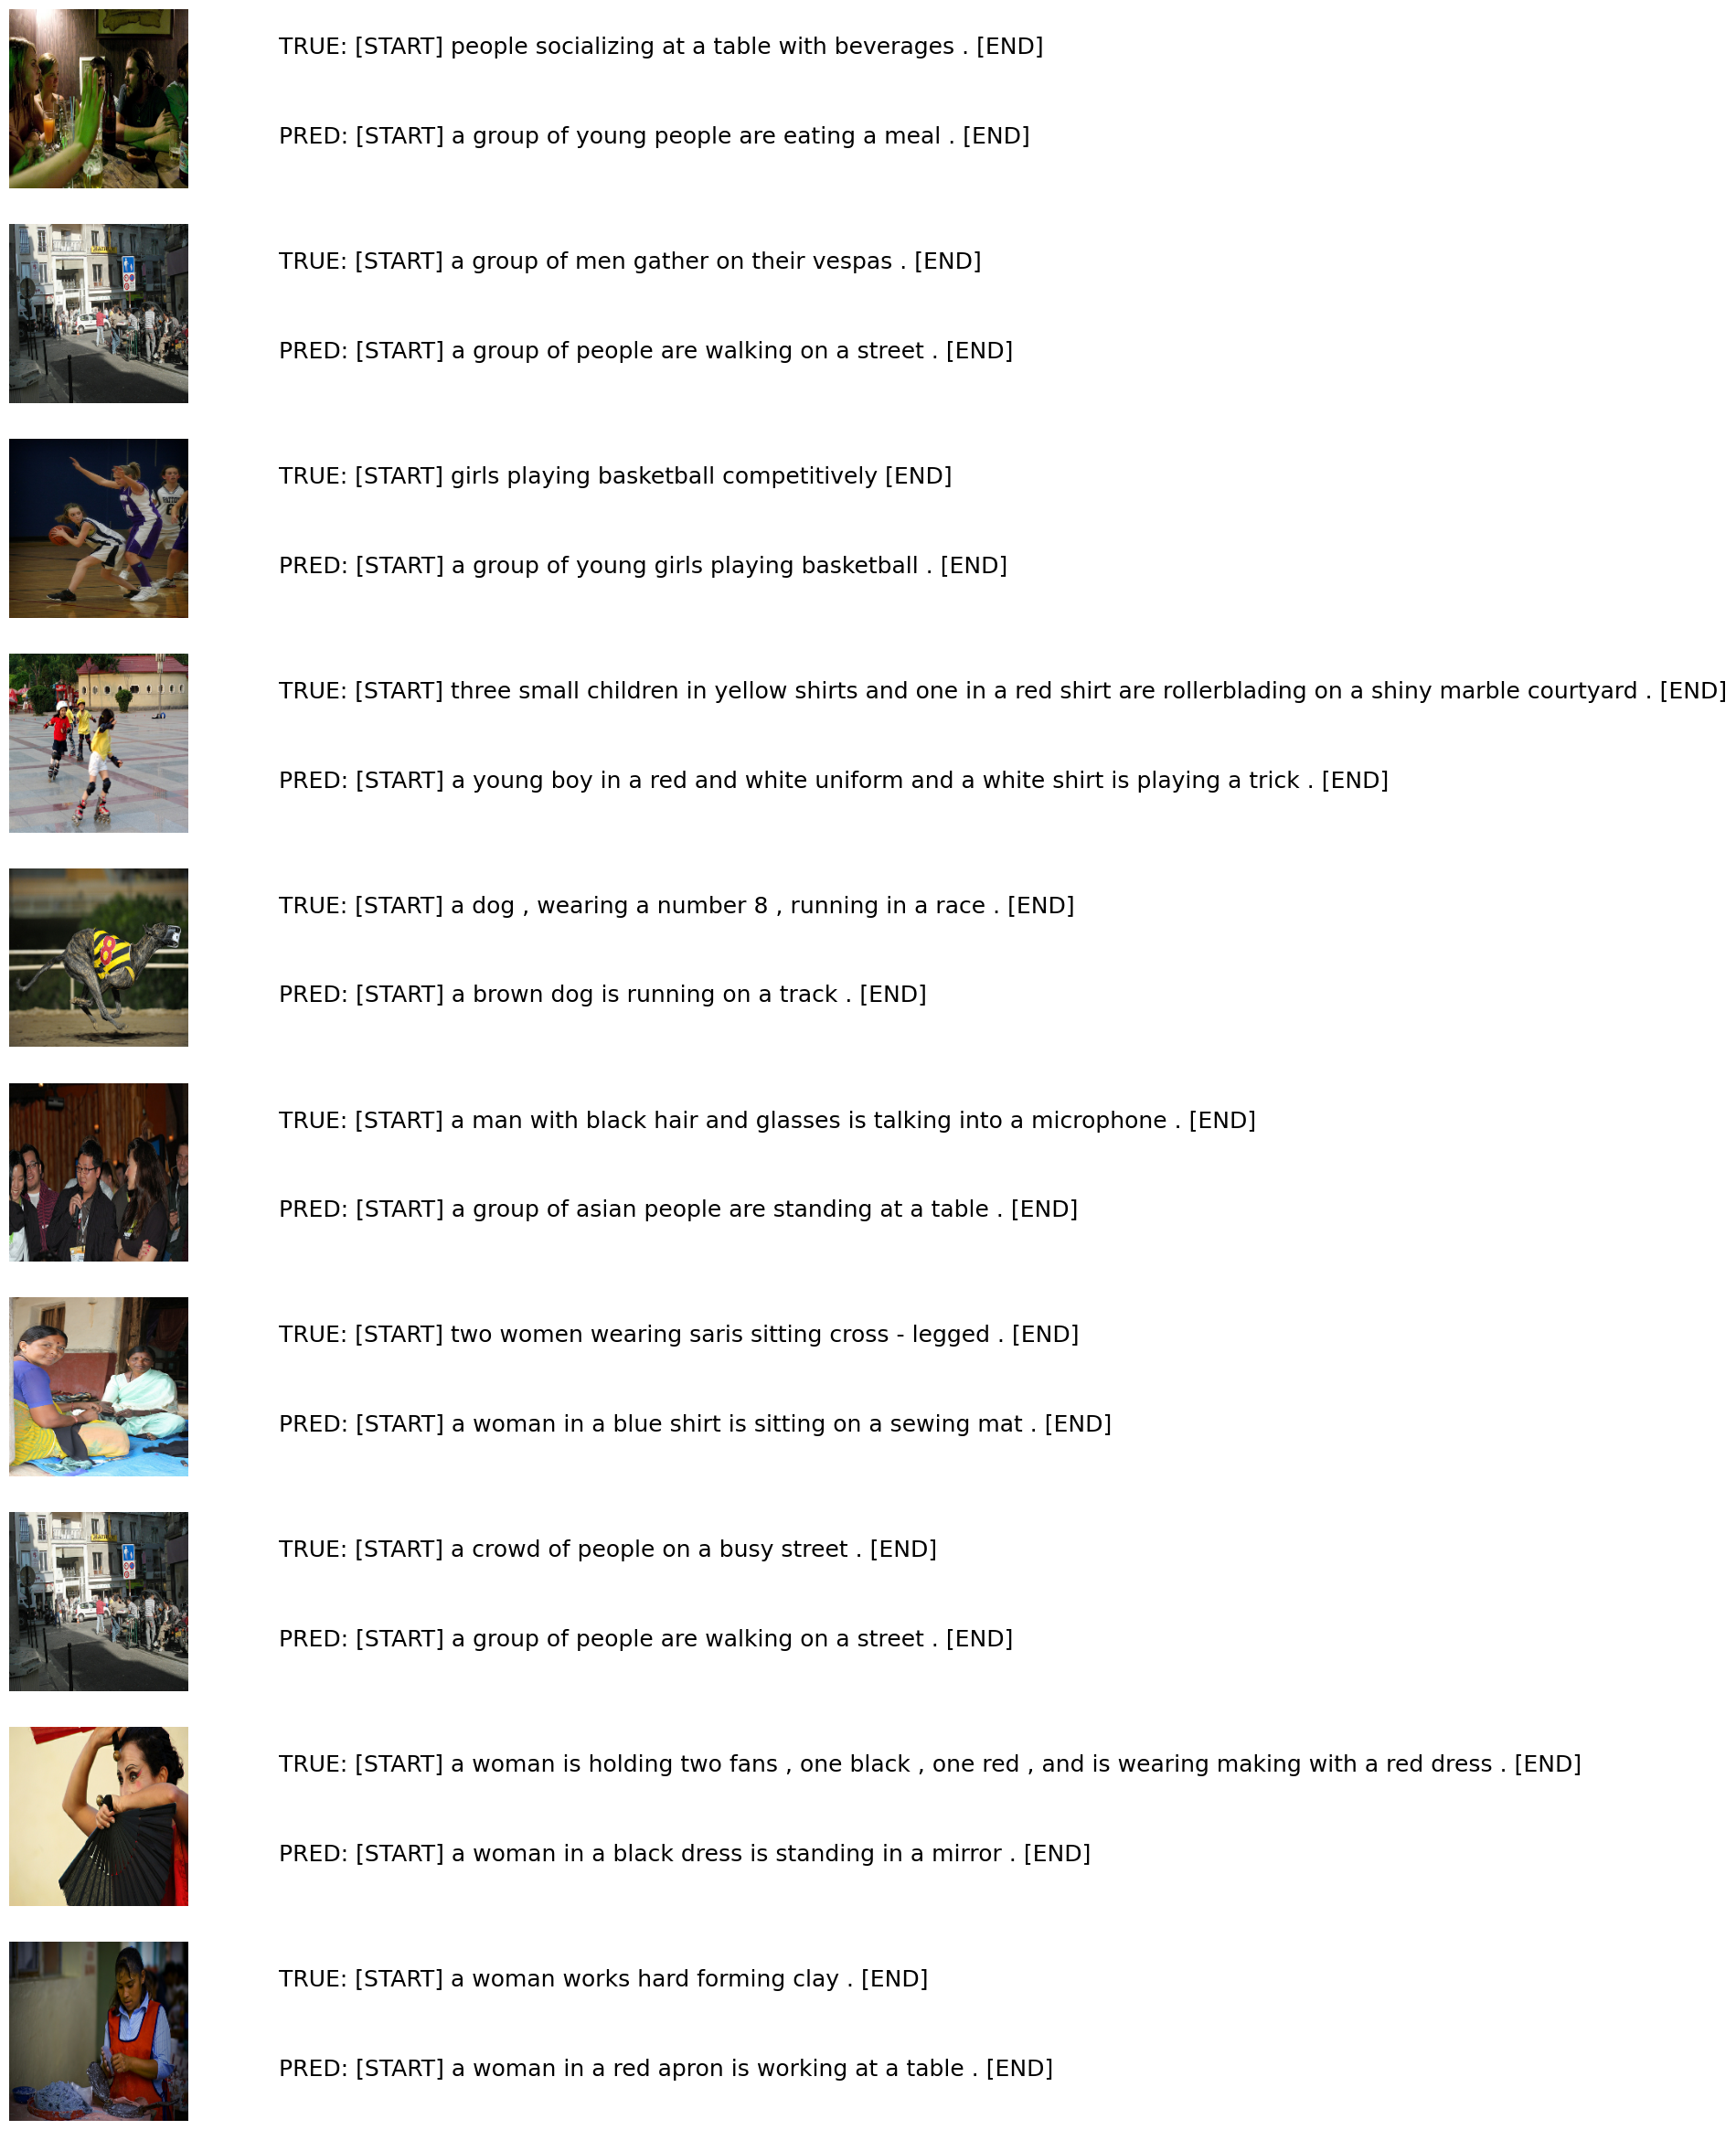

In [53]:
n_samples = 10
test_dataset, _ = generate_tf_dataset(
    test_df.sample(n=n_samples), tokenizer=tokenizer, n_vocab=n_vocab, batch_size=n_samples, training=False
)

def generate_caption(model, image_input, tokenizer, n_samples):
    # 2 -> [START]
    batch_tokens = np.repeat(np.array([[2]]), n_samples, axis=0)
    
    for i in range(30):
        if np.all(batch_tokens[:,-1] == 3):
            break
            
        position_input = tf.repeat(tf.reshape(tf.range(i+1),[1,-1]), n_samples, axis=0)
        probs = full_model((image_input, batch_tokens, position_input)).numpy()
        batch_tokens = np.argmax(probs, axis=-1)
    
    predicted_text = []
    for sample_tokens in batch_tokens:
        sample_predicted_token_ids = sample_tokens.ravel()
        sample_predicted_tokens = []
        for wid in sample_predicted_token_ids:
            sample_predicted_tokens.append(tokenizer.id_to_token(wid))
            if wid == 3:
                break
        sample_predicted_text = " ".join([tok for tok in sample_predicted_tokens])
        sample_predicted_text = sample_predicted_text.replace(" ##", "")
        predicted_text.append(sample_predicted_text)
    
    return predicted_text
    
    
for batch in test_dataset.take(1):
    (batch_image_input, _, _), batch_true_caption = batch

batch_predicted_text = generate_caption(full_model, batch_image_input, tokenizer, n_samples)

fig, axes = plt.subplots(n_samples, 2, figsize=(8,30))

for i,(sample_image_input, sample_true_caption, sample_predicated_caption) in enumerate(zip(batch_image_input, batch_true_caption, batch_predicted_text)):
    
    sample_true_caption_tokens  = [tokenizer.id_to_token(wid) for wid in sample_true_caption.numpy().ravel()]
    
    sample_true_text = []
    for tok in sample_true_caption_tokens:
        sample_true_text.append(tok)
        if tok == '[END]':
            break
    
    sample_true_text = " ".join(sample_true_text).replace(" ##", "")
    axes[i][0].imshow(((sample_image_input.numpy()+1.0)/2.0))
    axes[i][0].axis('off')
    
    true_annotation = f"TRUE: {sample_true_text}"
    predicted_annotation = f"PRED: {sample_predicated_caption}"
    axes[i][1].text(0, 0.75, true_annotation, fontsize=18)
    axes[i][1].text(0, 0.25, predicted_annotation, fontsize=18)
    axes[i][1].axis('off')